In [1]:
%run "..\src\utils\notebook_style.ipynb"

In [2]:
# Symbole für Zustandslinien Biegeträger

EI, x, F_A, F_B, F_C,  f_B, f_A, f_C = sp.symbols('EI x F_A F_B F_C  f_B, f_A, f_C')
c_1, c_2, c_3,c_4 = sp.symbols('c_1:5', real=True)
a_1, a_2, a_3, a_4 = sp.symbols('a_1:5', positive=True)
b_auflager, l_tot = sp.symbols('b_Auflager l_tot', positive=True)
q_x = sp.Function('q')(x)
M_x = sp.Function('M')(x)
V_x = sp.Function('V')(x)
w_x = sp.Function('w')(x)
phi_x = sp.Function('phi')(x)
w_1_gerissen_norm = sp.symbols('w_1_II\,SIA')



# Symbole für Integration der Krümmung

f_ct, E_c, b, h, W_c, M_r, E_s, f_c= sp.symbols('f_ct, E_c, b, h, W_c, M_r E_s f_c')
A_i, A_c, A_s, s_x, diam_s = sp.symbols('A_i, A_c, A_s, s_x \\oslash_s')
chi_r, I_1 = sp.symbols('chi_r, I^I')
zeta_c, c_nom, I_2 = sp.symbols('zeta_c c_nom I^{II}')
chi_M = sp.Function('chi')(M)
sigma_c_inf_1, F_c1, z_1 = sp.symbols('sigma_c_inf\,1, F_c\,1 z_1')
z_2 = sp.symbols('F_c\,2 z_2')
F_z2, F_c2, f_sy, x_2, epsilon_s2, epsilon_c2, sigma_s2, chi_II, sigma_c_inf_2, M_2 = sp.symbols('F_z\,2 F_c\,2 f_sy x_2 varepsilon_s\,2 varepsilon_c\,2 sigma_s\,2 \chi^{II} sigma_c_inf\,2 M_2')
EI_II, EI_I = sp.symbols('EI^{II} EI^I')
epsilon_sy, x_3, F_c3, F_s3, chi_y, M_y, sigma_c_inf_3 = sp.symbols('varepsilon_sy x_3 F_c\,3, F_s\,3, \chi_y M_y sigma_c_inf\,3')
x_4, M_R, epsilon_cw, epsilon_su,epsilon_sw, chi_u = sp.symbols('x_4 M_R varepsilon_cw varepsilon_su varepsilon_sw chi_u')
EI_III = sp.symbols('EI^{III}')
w_1 = sp.symbols('w_1')
f_su = sp.symbols('f_su')

epsilon_s, epsilon_c = sp.symbols('varepsilon_s varepsilon_c')
sigma_epsilon_s = sp.Function('sigma_s')(epsilon_s)
sigma_epsilon_c = sp.Function('sigma_c')(epsilon_c)



# Symbole für Zugversteifung

lamb, rho_eff, s_rm, w_r, sigma_sr, sigma_sr0 = sp.symbols('lambda rho_eff s_rm w_r sigma_sr sigma_sr0')
delta_chi = sp.Function('\Delta\\chi')(lamb)

Eq_list = []

In [3]:
# Versuch A3V2

params_krummung = {
    f_ct:4.*unit.N / unit.mm**2,
    E_c:37700.*unit.N / unit.mm**2,
    E_s:200000.*unit.N / unit.mm**2,
    s_x: 80.*unit.mm,
    diam_s:12.*unit.mm,
    c_nom:20.*unit.mm,
    f_sy:546.*unit.N/unit.mm**2,
    f_su:630.3*unit.N/unit.mm**2,
    f_c: 58.8*unit.N/unit.mm**2,
    epsilon_cw : 4/1000,
    epsilon_sw : 111.7/1000,
}

params_zustandslinien = {
    b_auflager: 100*unit.mm, #Auflagerbreite
    a_1: 0.11*unit.m, #abstand zu A von 0
    a_2:0.64*unit.m, #abstand von A zu C
    a_3:0.92*unit.m, #abstand von C zu B
    a_4:0.95*unit.m, #abstand von B zu D
    b:800.*unit.mm, # Breite des Trägers
    h:200.*unit.mm, # Höhe des Trägers,

}


In [4]:


Laststufe = 337*10**3
params = dict(params_krummung)
params.update(params_zustandslinien)

params_plot = param_value(params)

# Deformationsberechnung an Dreipunktbiegeversuch

## Versuchsbeschrieb

Gewählt wird aus @Jaeger2006 der Versuch:

## Zustandslinien für Biegeträger

Nach @Marti Kapitel 18.4:

Es wird in diesem Kapitel keine Herleitung der Beziehung zwischen Einwirkung und der Deformation dargestellt. Der Fokus liegt auf der praktischen Anwendung.




![Statisches System der Versuchsanordnung](../images/System_anordnung_2.svg){#fig-system_2}

Das Eigengewicht wird vernachlässigt aus folgenden Gründen:

- Die Punktlast $F_A$ ist massgebend am Biegemomentenverlauf beteiligt.
- Die Deformationen im Versuchsbericht aus @Jaeger2006 sind nach dem Einbau des Trägers gemessen worden. Folglich wurde die Deformation des Eigengewichts nicht aufgezeichnet.

$$
g_M, g_{k1}, g_{k2} = 0
$${#eq-eigengewicht}

Unter Berücksichtigung der Auflagerbreiten folgt das System in @fig-system_2_lager

![Angepasstes statisches System der Versuchsanordnung](../images/System_anordnung_2_lagerbreite.svg){#fig-system_2_lager}


Folgende Parameter werden für die Berechnung verwendet:

In [5]:
dict_to_table(params_zustandslinien)

|   |   |
|---|---|
| $a_{1} = 0.11 \, \text{m}$ | $a_{2} = 0.64 \, \text{m}$ |
| $a_{3} = 0.92 \, \text{m}$ | $a_{4} = 0.95 \, \text{m}$ |
| $b = 800.0 \, \text{mm}$ | $b_{Auflager} = 100 \, \text{mm}$ |
| $h = 200.0 \, \text{mm}$ | |


### Auflagerkräfte

Durch Gleichgewicht der Momente um Punkt C und B lassen sich die Auflagerkräfte bestimmen:

Die Balkenlänge bestimmt sich zu:

In [6]:
eq_l_tot = sp.Eq(l_tot, a_1 + a_2+a_3+a_4)

eq_l_tot_num = num_eq(eq_l_tot)
params[l_tot] = eq_l_tot_num.rhs
display(eq_l_tot,eq_l_tot_num.evalf(3))

lₜₒₜ = a₁ + a₂ + a₃ + a₄

lₜₒₜ = 2.62⋅meter

Durch Gleichgewicht um die Auflagerpunkte folgt:

In [7]:
eq_ggw_M_C = sp.Eq(0, F_A*a_2-F_B * a_3)
eq_ggw_M_B = sp.Eq(0,F_A * (a_2+a_3)-F_C * a_3)


ggw_solve = sp.solve([eq_ggw_M_C, eq_ggw_M_B], [F_C,F_B])


display(eq_ggw_M_C, eq_ggw_M_B)

0 = F_A⋅a₂ - F_B⋅a₃

0 = F_A⋅(a₂ + a₃) - F_C⋅a₃

Daraus folgen die Reaktionskräfte:

In [8]:

eq_F_B = sp.Eq(F_B,ggw_solve[F_B])

eq_F_C = sp.Eq(F_C,ggw_solve[F_C])

display(eq_F_B, eq_F_C)

      F_A⋅a₂
F_B = ──────
        a₃  

      F_A⋅a₂ + F_A⋅a₃
F_C = ───────────────
             a₃      

Um die Auflagerbreite zu berücksichtigen folgen die Kräfte zu:

In [9]:
eq_f_B = sp.Eq(f_B, F_B/b_auflager).subs(F_B, eq_F_B.rhs)


display(eq_f_B)

          F_A⋅a₂   
f_B = ─────────────
      a₃⋅b_Auflager

In [10]:
eq_f_C = sp.Eq(f_C, F_C/b_auflager).subs(F_C, eq_F_C.rhs)

display(eq_f_C)

      F_A⋅a₂ + F_A⋅a₃
f_C = ───────────────
       a₃⋅b_Auflager 

In [11]:
eq_f_A = sp.Eq(f_A, F_A/b_auflager)
display(eq_f_A)

         F_A    
f_A = ──────────
      b_Auflager

Anhand der Differentialgleichung für Biegeträger können die Zustandslinien bestimmt werden:

In [12]:
DGL_biegetraeger = sp.Eq(q_x, -EI_I*sp.Derivative(w,x,4))
display(DGL_biegetraeger)

                4   
               d    
q(x) = -EI__I⋅───(w)
                4   
              dx    

Die Biegesteifigkeit des Querschnitts folgt zu:

In [13]:
eq_EI = sp.Eq(EI, E_c * b*h**3/12)
eq_EI_num = eq_EI.subs(params)
display(eq_EI, eq_EI_num.evalf(3))

            3
     E_c⋅b⋅h 
EI = ────────
        12   

                        2       
EI = 2.01e+13⋅millimeter ⋅newton

In [14]:
eq_q_x = sp.Eq(q_x, sp.Piecewise(
    (0, (x>0)&(x<=(a_1 - b_auflager/2))),
    (eq_f_A.rhs, (x>(a_1 - b_auflager/2))&(x<(a_1 + b_auflager/2))),
    (0, (x>(a_1 + b_auflager/2))&(x<((a_1+a_2) - b_auflager/2))),
    (-eq_f_C.rhs, (x>((a_1+a_2) - b_auflager/2))&(x<((a_1+a_2)+ b_auflager/2))),
    (0, (x>((a_1+a_2)+ b_auflager/2))&(x<((a_1+a_2+a_3) - b_auflager/2))),
    (eq_f_B.rhs, (x>((a_1+a_2+a_3) - b_auflager/2))&(x<((a_1+a_2+a_3) + b_auflager/2))),
    (0, True)
    )).simplify()

params_plot = param_value(params)
eq_q_x_num = eq_q_x.subs(params_plot)


In [15]:
x_array = np.linspace(0,np.float64((eq_l_tot.rhs).subs(params_plot)),1000)


q_x_lamb = sp.lambdify((F_A, x),eq_q_x_num.rhs, 'numpy')
q_x_array = q_x_lamb(Laststufe, x_array)


Der Verlauf der Einwirkungen ist der folgende. Die positive Stabseite ist strichliert dargestellt. Folglich sind Einwirkungen nach "unten" positiv definiert.

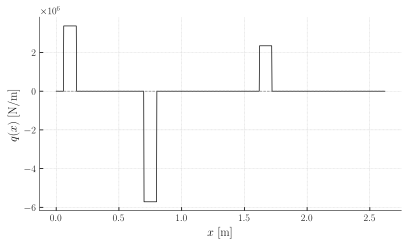

In [16]:
#| label: fig-q_x
#| fig-cap: Verlauf der Einwirkungen und Reaktionskräften
plt.plot(x_array, q_x_array, color='black')
plt.plot(x_array, 0*x_array, color='gray', linestyle='dashed')

plt.xlabel(f'${sp.latex(x)}$ [m]')
plt.ylabel(f'${sp.latex(q_x)}$ [N/m]')
plt.show()


Durch Integration der Einwirkung resultiert der Querkraftverlauf. Die Integrationskonstante ist hier null.

$$
V(x) = -\int q(x) + c_1
$$

Dabei kann mit der Randbedingun $V(0) = 0$ die Integrationskonstante ermittelt werden.

In [17]:
eq_V_x = sp.Eq(-V_x,sp.integrate(eq_q_x_num.rhs, x) + c_1)
c_1_num = sp.solve(eq_V_x.rhs.subs(x,0).subs(params),c_1)[0]

V_x_solve = eq_V_x.subs(c_1, c_1_num).simplify()

V_x_lamb = sp.lambdify((F_A,x),V_x_solve.rhs, 'numpy')

V_x_array = V_x_lamb(Laststufe,x_array)

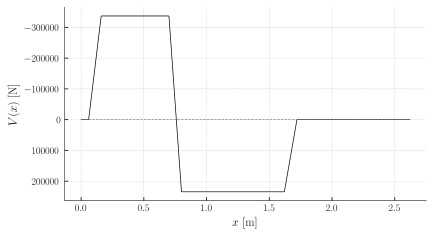

In [18]:
#| label: fig-V_X
#| fig-cap: Verlauf der Querkräfte 

plt.plot(x_array, V_x_array, color='black')
plt.plot(x_array, 0*x_array, color='gray', linestyle='dashed')

plt.gca().invert_yaxis()
plt.xlabel(f'${sp.latex(x)}$ [m]')
plt.ylabel(f'${sp.latex(V_x)}$ [N]')
plt.show()


Der Verlauf der Biegemoment lässt sich durch Integration der Querkräfte bestimmen:


$$
M(x) = \int V(x) + c_2
$$

Dabei kann mit der Randbedingun $M(0) = 0$ die Integrationskonstante ermittelt werden.

In [19]:
eq_M_x = sp.Eq(M_x, sp.integrate(V_x_solve.rhs,x)+c_2)
c_2_num = sp.solve(eq_M_x.subs(x,0).rhs.subs(params), c_2)[0]
M_x_solve = eq_M_x.subs(c_2, c_2_num).simplify()
M_x_lamb = sp.lambdify((F_A, x),M_x_solve.rhs, 'numpy')

M_x_array = M_x_lamb(Laststufe, x_array)


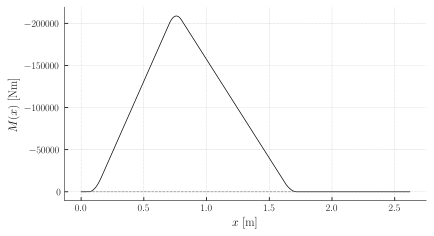

In [20]:
#| label: fig-M_x
#| fig-cap: Verlauf der Biegemomente 

plt.plot(x_array, M_x_array, color='black')
plt.plot(x_array, 0*x_array, color='gray', linestyle='dashed')

plt.gca().invert_yaxis()
plt.xlabel(f'${sp.latex(x)}$ [m]')
plt.ylabel(f'${sp.latex(M_x)}$ [Nm]')
plt.show()

In [21]:
eq_phi_x = sp.Eq(phi_x, sp.integrate(M_x_solve.rhs/EI,x)+c_3).subs(EI, eq_EI.rhs)


Die Deformationen entsprechen dem Integrierten Verlauf der Biegemomente, dividiert durch die Biegesteifigkeit, welche als konstant angesetzt wird.

$$
\phi(x) = \frac{1}{EI}\int M(x) + c_3
$${#eq-verdrehung}


$$
w(x) = \int \phi(x) + c_4
$${#eq-verformung}


Dabei wird mit den Randbedingungen $w(C) = 0$ und $w(B) = 0$ die Integrationskonstanten ermittelt.



In [22]:
eq_w_x = sp.Eq(w_x, sp.integrate(eq_phi_x.rhs, x)+ c_4)
eq_w_x.subs(params_plot)
c_solve = sp.solve([eq_w_x.rhs.subs(x,a_1 + a_2).subs(params_plot), eq_w_x.rhs.subs(x,a_1 + a_2+a_3).subs(params_plot)],[c_3, c_4])


eq_w_x_solve = eq_w_x.subs(c_solve).subs(params_plot)


w_x_lamb = sp.lambdify((F_A,x),eq_w_x_solve.rhs)

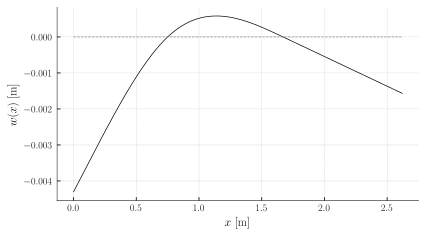

In [23]:
w_x_array = w_x_lamb(Laststufe, x_array)


#| label: fig-w_x
#| fig-cap: Verlauf der Deformation 

plt.plot(x_array, w_x_array, color='black')
plt.plot(x_array, 0*x_array, color='gray', linestyle='dashed')

plt.xlabel(f'${sp.latex(x)}$ [m]')
plt.ylabel(f'${sp.latex(w_x)}$ [m]')
plt.show()

Dabei folgt die Deformation $w_1 = w(0.11)$, das vorzeichen wird vernachlässigt. Das erhaltene Resultat entspricht einem vollumfänglich ungerissenen Verhalten.

In [24]:
eq_w_1_elastisch = sp.Eq(w_1,-unit.convert_to(w_x_lamb(Laststufe, 0.11)*unit.m,unit.mm))
display(eq_w_1_elastisch.evalf(3))

w₁ = 3.56⋅millimeter

## Abschätzung nach Norm
Nach der bestimmten elastischen Deformation kann die Deformation anhand des vollständig gerissenen Querschnitts nach SIA262 ermittelt werden. Ohne Druckbewehrung und Kriecheinflüsse folgt die Gleichung zu :


$$
w_{1II,SIA} = \frac{0.75}{10\rho^{0.7}}(\frac{h}{d})^3 w_1
$${#eq-w_1_II_sia}

Dabei entspricht der geometrische Bewehrugnsgehalt:

In [25]:
eq_rho = sp.Eq(rho, A_s/(b*d))
Eq_list.append(eq_rho)

display(eq_rho)

     Aₛ
ρ = ───
    b⋅d

Die Querschnittsfläche der Stäbe:

In [26]:
eq_A_s = sp.Eq(A_s, sp.Mul(2*b,sp.pi * diam_s **2 / (4 * s_x), evaluate=False))
eq_A_s_num = unit.convert_to(num_eq(eq_A_s), unit.mm)
display(eq_A_s, eq_A_s_num.evalf(4))

                   2
         π⋅\oslashₛ 
Aₛ = 2⋅b⋅───────────
             4⋅sₓ   

                      2
Aₛ = 2262.0⋅millimeter 

Die statische Höhe:

In [27]:
eq_d = sp.Eq(d,h - c_nom - sp.Rational(1.5) * diam_s)
eq_d_num = num_eq(eq_d)
display(eq_d, eq_d_num.evalf(3))


      3⋅\oslashₛ           
d = - ────────── - cₙₒₘ + h
          2                

d = 162.0⋅millimeter

Die Deformation entspricht abschliessend:

In [28]:
eq_w_1_gerissen_norm = sp.Eq(w_1_gerissen_norm, sp.Mul(0.75/(10*rho)**sp.Rational(0.7) , (h/d)**3 * w_1, evaluate=False))
eq_w_1_gerissen_norm_num = unit.convert_to(eq_subs(eq_w_1_gerissen_norm, eq_rho, eq_A_s, eq_d, eq_w_1_elastisch).subs(params), unit.mm)
display(eq_w_1_gerissen_norm_num.evalf(3))

w_1_II,SIA = 17.1⋅millimeter

## Numerische Integration der Krümmung

### Einführung

Ziel ist die Deformationen des Versuchs A3 in der Versuchsanordnung 2 aus @Jaeger2006 nachzurechnen.

### Momenten-Krümmungsdiagramm

Das Momenten-Krümmungsdiagramm ist geeignet zur Beschreibung des Tragverhaltens von überwiegend auf Biegung beanspruchte Stabtragwerke.
Zur rechnerischen Ermittlung gelten folgende Annahmen, wie in @Spathelf2022 beschrieben:

- Eben- und senkrechtbleiben der Querschnitte
- Die Betonzugfestigkeit $f_{ct}$ wird, für Zustände nach dem Überschreiten von $f_{ct}$, vernachlässigt
- Linear elastisches Verhalten von Stahl und Beton für die Spannungs- und Verformungsberechnung
- Die Bewehrung überträgt Zug- und Druckkräfte ausschliesslich in Stabrichtung

#### Anwendung auf Versuchsbeispiel

Folgend wird ein Momentenkrümmungsdiagramm für den Querschnitt aus dem beschriebenen Versuch berechnet. Die vorhandene Querkraftbewehrung ist nicht dargestellt in @fig-qs_a3.


![Querschnitt des Versuchs A3 zur Bestimmung des Momenten-Krümmungdiagramms](../images/QS_Versuch_A3.svg){#fig-qs_a3}


Vereinfacht wird der Querschnitt folgender massen:


![Vereinfachung der Bewehrungsführung](../images/QS_analyse_1.svg){#fig_qs_1}


##### Verwendete Parameter

In [29]:
dict_to_table(params_krummung)

|   |   |
|---|---|
| $E_{c} = 37700.0 \, \frac{\text{N}}{\text{mm}^{2}}$ | $E_{s} = 200000.0 \, \frac{\text{N}}{\text{mm}^{2}}$ |
| $\oslash_{s} = 12.0 \, \text{mm}$ | $c_{nom} = 20.0 \, \text{mm}$ |
| $f_{c} = 58.8 \, \frac{\text{N}}{\text{mm}^{2}}$ | $f_{ct} = 4.0 \, \frac{\text{N}}{\text{mm}^{2}}$ |
| $f_{su} = 630.3 \, \frac{\text{N}}{\text{mm}^{2}}$ | $f_{sy} = 546.0 \, \frac{\text{N}}{\text{mm}^{2}}$ |
| $s_{x} = 80.0 \, \text{mm}$ | $\varepsilon_{cw} = 0.004$ |
| $\varepsilon_{sw} = 0.1117$ | |


##### Baustoffkennlinien

In [30]:
eq_1 = sp.Eq(f_sy, a +b*f_sy/E_s)
eq_2 = sp.Eq(f_su, a + b*epsilon_sw)



eq_lin = sp.Eq(sigma_epsilon_s, a + b * epsilon_s).subs(sp.solve([eq_1,eq_2],[a,b]))

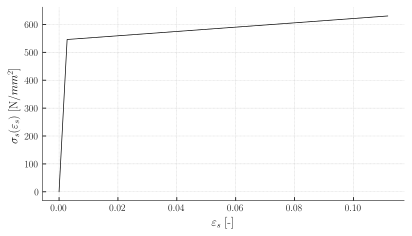

In [31]:
eq_sigma_epsilon_s = sp.Eq(sigma_epsilon_s, sp.Piecewise(
    (E_s * epsilon_s, (epsilon_s<=f_sy / E_s)&(epsilon_s>=0)),
    (eq_lin.rhs.subs(params_plot), (epsilon_s<=epsilon_sw)&(epsilon_s>=f_sy / E_s))
    ))




eq_sigma_epsilon_s_num = eq_sigma_epsilon_s.subs(params_plot) 
eq_sigma_epsilon_s_lamb = sp.lambdify((epsilon_s),eq_sigma_epsilon_s_num.rhs)


epsilon_s_array = np.linspace(0, np.float64(epsilon_sw.subs(params_plot)), 2000)
eq_sigma_epsilon_array = eq_sigma_epsilon_s_lamb(epsilon_s_array)

#| label: fig-stahlkennlinie
#| fig-cap: Spannungs-Dehnungs Diagramm des Bewehrungsstahls als Grundlage der Handrechnung

plt.plot(epsilon_s_array, eq_sigma_epsilon_array/1000**2, color='black')

plt.xlabel(f'${sp.latex(epsilon_s)}$ [-]')
plt.ylabel(f'${sp.latex(sigma_epsilon_s)}$ [N/$mm^2$]')

plt.show()

##### Schwerpunkt des Querschnitts

Durch die Bestimmung der Wertigkeit $n$ kann der Querschnitt als homogener Betonquerschnitt zur Bestimmung des Schwerpunkts behandelt werden.

In [32]:
eq_n = sp.Eq(n, E_s / E_c)
eq_n_num = num_eq(eq_n)



display(eq_n,eq_n_num.evalf(3))

     Eₛ
n = ───
    E_c

n = 5.3

Die Querschnittsfläche der Bewehrung:

In [33]:


display(eq_A_s, eq_A_s_num.evalf(3))

                   2
         π⋅\oslashₛ 
Aₛ = 2⋅b⋅───────────
             4⋅sₓ   

                       2
Aₛ = 2.26e+3⋅millimeter 

Die Betonquerschnittsfläche:

In [34]:
eq_A_c = sp.Eq(A_c, b*h)
eq_A_c_num = unit.convert_to(num_eq(eq_A_c), unit.mm)


display(eq_A_c, eq_A_c_num)

A_c = b⋅h

                         2
A_c = 160000.0⋅millimeter 

Die ideelle Querschnittsfläche resultiert zu:

In [35]:
eq_Ai = sp.Eq(A_i, A_c + A_s *(n-1))
eq_Ai_num = unit.convert_to(num_eq(eq_Ai), unit.mm)


display(eq_Ai,eq_Ai_num.evalf(6))

Aᵢ = A_c + Aₛ⋅(n - 1)

                        2
Aᵢ = 169738.0⋅millimeter 

In [36]:
eq_zeta_c = sp.Eq(zeta_c, sp.Mul(1/A_i,A_c * h/2 + A_s*(n-1) * (c_nom +1.5*diam_s), evaluate=False))
eq_zeta_c_num = unit.convert_to(num_eq(eq_zeta_c), unit.mm)

display(eq_zeta_c, eq_zeta_c_num.simplify().evalf(3))

      A_c⋅h                                   
      ───── + Aₛ⋅(1.5⋅\oslashₛ + cₙₒₘ)⋅(n - 1)
        2                                     
ζ_c = ────────────────────────────────────────
                         Aᵢ                   

ζ_c = 96.4⋅millimeter

##### Flächenträgheitsmoment

Das Flächenträgheitsmoment wird ebenfalls am ideellen Querschnitt bestimmt. Die Eigenträgheitsmomente der Kreisquerschnitte der Bewehrung sind nicht berücksichtigt, lediglich der Steiner-Anteil fliesst in die Berechnung ein:

In [37]:
eq_I_1 = sp.Eq(I_1, b * h**3/12 +b*h*(h/2 - zeta_c)**2 + A_s * (n-1) * (c_nom + sp.Rational(1.5)*diam_s - zeta_c)**2)
eq_I_1_num = unit.convert_to(num_eq(eq_I_1), unit.mm)
display(eq_I_1, eq_I_1_num.evalf(3))


                                           2      3                2
                  ⎛3⋅\oslashₛ             ⎞    b⋅h        ⎛h      ⎞ 
I__I = Aₛ⋅(n - 1)⋅⎜────────── + cₙₒₘ - ζ_c⎟  + ──── + b⋅h⋅⎜─ - ζ_c⎟ 
                  ⎝    2                  ⎠     12        ⎝2      ⎠ 

                         4
I__I = 5.69e+8⋅millimeter 

##### Ungerissen - Zustand 1

Der Querschnitt verbleibt elastisch. Folglich kann das Flächenträgheitsmoment mit $E_c$ multipliziert werden und es resultiert die ungerissene Biegesteifigkeit:

In [38]:

eq_EI_1 = sp.Eq(EI_I, I_1 * E_c)
eq_EI_I_num = num_eq(eq_EI_1)



display(eq_EI_1, eq_EI_I_num.evalf(3))

EI__I = E_c⋅I__I

                           2       
EI__I = 2.14e+13⋅millimeter ⋅newton

###### Rissmoment

Durch die Ermittlung des Rissmoments kann die Krümmung vor dem Reissen des Betons ermittelt werden. Die Betonzugkraft wird nicht berücksichtigt.

![Querschnittsanalyse vor dem Reissen des Betons](../images/QS_analyse_2.svg){#fig-qs2}


Die Druckspannung bestimmt sich zu:

In [39]:
eq_sigma_c_inf1 = sp.Eq(sigma_c_inf_1,f_ct / zeta_c * (h-zeta_c))
eq_sigma_c_inf1_num = unit.convert_to(num_eq(eq_sigma_c_inf1),unit.mm)


display(eq_sigma_c_inf1, eq_sigma_c_inf1_num.evalf(3))


            f_ct⋅(h - ζ_c)
σ_c_inf,1 = ──────────────
                 ζ_c      

            4.29⋅newton
σ_c_inf,1 = ───────────
                      2
            millimeter 

Der Hebelarm der inneren Kräfte:

In [40]:
eq_z_r = sp.Eq(z_1, h - ((h-zeta_c)/3 + c_nom + 3/2 * diam_s))
eq_z_r_num = unit.convert_to(num_eq(eq_z_r), unit.mm)

display(eq_z_r, eq_z_r_num.evalf(3))

                            2⋅h   ζ_c
z₁ = -1.5⋅\oslashₛ - cₙₒₘ + ─── + ───
                             3     3 

z₁ = 128.0⋅millimeter

Die Betondruckkraft:

In [41]:
eq_F_c_r = sp.Eq(F_c1,  sigma_c_inf_1 * b * (h-zeta_c)/2)
eq_F_c_r_num = num_eq(eq_F_c_r)

display(eq_F_c_r, eq_F_c_r_num.evalf(3))


        b⋅σ_c_inf,1⋅(h - ζ_c)
F_c,1 = ─────────────────────
                  2          

F_c,1 = 1.78e+5⋅newton

Und schliesslich das Rissmoment:

In [42]:
eq_M_r = sp.Eq(M_r, F_c1 * z_1)
eq_M_r_num = num_eq(eq_M_r)


display(eq_M_r, eq_M_r_num.evalf(3))

Mᵣ = F_c,1⋅z₁

Mᵣ = 2.27e+7⋅millimeter⋅newton

Aus dem Rissmoment folgt die Krümmung beim Reissen:

In [43]:
eq_chi_r = sp.Eq(chi_r, M_r / (EI_I))
eq_chi_r_num = unit.convert_to(num_eq(eq_chi_r), unit.m)


display(eq_chi_r,eq_chi_r_num.evalf(3))

       Mᵣ 
χᵣ = ─────
     EI__I

     0.00106
χᵣ = ───────
      meter 

##### Gerissen Elastisch - Zustand 2

Der Querschnitt nach dem Reissen ist in @fig-qs3 dargestellt. Der Betonstahl hat die Fliessgrenze noch nicht erreicht. Der Beton die Druckfestigkeit ebenfalls nicht.

![Querschnittsanalyse nach dem Reissen des Betons](../images/QS_analyse_3.svg){#fig-qs3}

Dabei beträgt die statische Höhe:

In [44]:
eq_d = sp.Eq(d,h - c_nom - sp.Rational(1.5) * diam_s)
eq_d_num = num_eq(eq_d)

display(eq_d, eq_d_num)

      3⋅\oslashₛ           
d = - ────────── - cₙₒₘ + h
          2                

d = 162.0⋅millimeter

Nachfolgend werden bekannte Beziehungen dargestellt. Mittels Gleichgewicht der Kräfte lässt sich die Betondruckzonenhöhe und folglich die gerissene Biegesteifigkeit herleiten.

Die Betonstahlzugkraft beträgt:


In [45]:
eq_F_z2 = sp.Eq(F_z2, sigma_s2*A_s)

Eq_list.append(eq_F_z2)

display(eq_F_z2)


F_z,2 = Aₛ⋅σ_s,2

Die Betonstahlspannung für linear elastisches Verhalten:

In [46]:
eq_sigma_s2 = sp.Eq(sigma_s2, epsilon_s2 * E_s)
Eq_list.append(eq_sigma_s2)
eq_sigma_s2

σ_s,2 = Eₛ⋅varepsilon_s,2

Die Betondruckkraft anhand des dreieckigen Verlaufs in @fig-qs3:


In [47]:
eq_F_c2 = sp.Eq(F_c2, sigma_c_inf_2 * b * x_2 /2)
Eq_list.append(eq_F_c2)
eq_F_c2


        b⋅σ_c_inf,2⋅x₂
F_c,2 = ──────────────
              2       

Die Betonspannung ebenfalls bestimmt durch ein linear elastisches Verhalten:

In [48]:
eq_sigma_c_inf2 = sp.Eq(sigma_c_inf_2, epsilon_c2* E_c)
Eq_list.append(eq_sigma_c_inf2)
eq_sigma_c_inf2

σ_c_inf,2 = E_c⋅varepsilon_c,2

Die Betondehnung anhand des Dehnungsverlaufs in @fig-qs3:

In [49]:
eq_epsilon_c2 = sp.Eq(epsilon_c2, epsilon_s2 /(d-x_2) * x_2)
Eq_list.append(eq_epsilon_c2)
eq_epsilon_c2

                 varepsilon_s,2⋅x₂
varepsilon_c,2 = ─────────────────
                       d - x₂     

Abschliessend sind die Kräfte ins Gleichgewicht zu setzen:

In [50]:
eq_ggw_1 = sp.Eq(F_c2, F_z2)
Eq_list.append(eq_ggw_1)
eq_ggw_1

F_c,2 = F_z,2

Einsetzen der bestimmten Gleichungen in die Gleichgewichtsbeziehung:

In [51]:

display(eq_n, eq_rho)

     Eₛ
n = ───
    E_c

     Aₛ
ρ = ───
    b⋅d

Dabei wird mit $n$ und $\rho$ substituiert um die Gleichung zu vereinfachen.

In [52]:
eq_ggw_1_subs = eq_subs(eq_F_c2, eq_sigma_c_inf2, eq_ggw_1, eq_epsilon_c2, eq_F_z2).subs(E_c, E_s/n).subs(sigma_s2, epsilon_s2 * E_s).subs(A_s, rho*b*d)
eq_ggw_1_subs

                                                2
                          Eₛ⋅b⋅varepsilon_s,2⋅x₂ 
Eₛ⋅b⋅d⋅ρ⋅varepsilon_s,2 = ───────────────────────
                                2⋅n⋅(d - x₂)     

Dies ist nach $x$ aufzulösen:

In [53]:
eq_x_2 = sp.Eq(x_2,sp.solve(eq_ggw_1_subs, x_2)[0])
eq_x_2_num = unit.convert_to(num_eq(eq_x_2),unit.mm)
Eq_list.append(eq_x_2)
display(eq_x_2, eq_x_2_num.evalf(3))

       ⎛         _______________⎞
x₂ = d⋅⎝-n⋅ρ + ╲╱ n⋅ρ⋅(n⋅ρ + 2) ⎠

x₂ = 56.3⋅millimeter

Zur Bestimmung der Krümmung ist die Betonstahldehnung erforderlich. Diese bedingt ein einwirkendes Moment. Dazu wird das bereits bekannte Rissmoment angesetzt.

In [54]:
eq_M_2 = sp.Eq(M_2, F_z2 * (d-x_2/3))
eq_M_2_M_r = sp.Eq(M_2, M_r)
Eq_list.append(eq_M_2)
Eq_list.append(eq_M_2_M_r)

display(eq_M_2,eq_M_2_M_r, eq_subs(eq_M_2,eq_M_2_M_r, eq_F_z2, eq_sigma_s2))

           ⎛    x₂⎞
M₂ = F_z,2⋅⎜d - ──⎟
           ⎝    3 ⎠

M₂ = Mᵣ

                          ⎛    x₂⎞
Mᵣ = Aₛ⋅Eₛ⋅varepsilon_s,2⋅⎜d - ──⎟
                          ⎝    3 ⎠

Daraus resultiert die Betonstahldehnung:

In [55]:
eq_epsilon_s2 = sp.Eq(epsilon_s2,sp.solve(eq_subs(eq_M_2, eq_x_2, eq_sigma_s2, eq_F_z2, eq_M_2_M_r), epsilon_s2)[0])

eq_epsilon_s2_num = num_eq(eq_epsilon_s2)
Eq_list.append(eq_epsilon_s2_num)


display(eq_epsilon_s2_num.evalf(3))

varepsilon_s,2 = 0.00035

Die Krümmung kann anhand des Dehnungsverlaufs in @fig-qs3 bestimmt werden:

In [56]:
eq_chi_II = sp.Eq(chi_II, epsilon_s2/(d-x_2))
eq_chi_II_num = unit.convert_to(eq_subs(eq_chi_II, eq_x_2_num, eq_d_num, eq_epsilon_s2_num).simplify(), unit.m)
Eq_list.append(eq_chi_II)

display(eq_chi_II,eq_chi_II_num.evalf(3))


             varepsilon_s,2
\chi__{II} = ──────────────
                 d - x₂    

             0.00331
\chi__{II} = ───────
              meter 

Abschliessend folgt die gerissene Biegesteifigkeit zu:

In [57]:

eq_EI_II = sp.Eq(EI_II, M_2 / chi_II)
eq_EI_II_num = eq_subs(eq_EI_II, *Eq_list).subs(params).simplify()

display(eq_EI_II,eq_EI_II_num.evalf(3))



               M₂    
EI__{II} = ──────────
           \chi__{II}

                              2       
EI__{II} = 6.85e+12⋅millimeter ⋅newton

##### Fliessen der Bewehrung - Zustand 3

Die Biegesteifigkeit $EI^{II}$ gilt bis die Bewehrung fliesst oder der Beton beginnt zu plastifizieren. 

![Querschnittsanalyse für reine Biegung beim Fliessen der Bewehrung](../images/QS_analyse_4.svg){#fig-qs4}

Dazu gilt es zuerst Gleichgewicht der Kräfte zu formulieren:

In [59]:
eq_sigma_c_inf3 = sp.Eq(sigma_c_inf_3,f_sy / E_s / (d-x_3) *x_3 * E_c)
eq_ggw_fliessen = sp.Eq(A_s * f_sy, x_3 * b * sigma_c_inf_3/2)
display(eq_sigma_c_inf3,eq_ggw_fliessen)

            E_c⋅f_sy⋅x₃
σ_c_inf,3 = ───────────
            Eₛ⋅(d - x₃)

          b⋅σ_c_inf,3⋅x₃
Aₛ⋅f_sy = ──────────────
                2       

Aufgelöst nach der Druckzonenhöhe:

In [60]:
eq_x_3 = sp.Eq(x_3,sp.solve(eq_subs(eq_ggw_fliessen, eq_sigma_c_inf3), x_3)[1])
Eq_list.append(eq_x_3)

eq_x_3_num = unit.convert_to(num_eq(eq_x_3), unit.mm)

display(eq_x_3, eq_x_3_num.evalf(3))

                ___________________________
     -Aₛ⋅Eₛ + ╲╱ Aₛ⋅Eₛ⋅(Aₛ⋅Eₛ + 2⋅E_c⋅b⋅d) 
x₃ = ──────────────────────────────────────
                     E_c⋅b                 

x₃ = 56.3⋅millimeter

Daraus lässt sich das Fliessmoment bestimmen, welches den Endpunkt im Momenten-Krümmungsdiagramm für den Zustand 2 definiert:

In [61]:
eq_M_y = sp.Eq(M_y, A_s * f_sy * (d-x_3/3))
eq_M_y_num = num_eq(eq_M_y)
display(eq_M_y, eq_M_y_num.evalf(3))

              ⎛    x₃⎞
M_y = Aₛ⋅f_sy⋅⎜d - ──⎟
              ⎝    3 ⎠

M_y = 1.77e+8⋅millimeter⋅newton

Die Fliessdehnung des Betonstahls entspricht:

In [62]:
eq_epsilon_sy = sp.Eq(epsilon_sy, f_sy / E_s)

Eq_list.append(eq_epsilon_sy)

eq_epsilon_sy.subs(params)

varepsilon_sy = 0.00273

Abschliessend die Krümmung für den Endpunkt des Zustands 2:

In [63]:
eq_chi_y = sp.Eq(chi_y, epsilon_sy / (d-x_3))

eq_chi_y_num = num_eq(eq_chi_y)

display(eq_chi_y, eq_chi_y_num.evalf(3))

         varepsilon_sy
\chi_y = ─────────────
             d - x₃   

          2.58e-5  
\chi_y = ──────────
         millimeter

##### Maximaler Biegewiderstand - Zustand 4

Abschliessen kann der maximale Biegewiderstand durch die plastifizierung der Betondruckzone bestimmt werden. Dem Stahl wird die statische Zugfestigkeit vorausgesetzt, dies berücksichtigt eine Verfestigung. Sowie gilt es zu kontrollieren, ob die Betonstahldehnung unterhalb der Bruchdehnung liegt.

![Querschnittsanalyse für reine Biegung beim Fliessen der Bewehrung und plastifizierter Betondruckzone](../images/QS_analyse_5.svg){#fig-qs5}

Vereinfacht werden die Spannungen in der Druckzone konstant verteilt betrachtet. Dazu wird die Druckzonenhöhe abgemindert um Faktor 0.85.

Das Gleichgewicht der Kräfte führt zu:

In [64]:
eq_ggw_R = sp.Eq(A_s * f_su, sp.Mul(0.85,x_4 * b * f_c, evaluate=False))

display(eq_ggw_R)

Aₛ⋅fₛᵤ = 0.85⋅b⋅f_c⋅x₄

Die Druckzonenhöhe folgt zu:

In [65]:
eq_x_4 = sp.Eq(x_4, sp.solve(eq_ggw_R, x_4)[0])
eq_x_4_num = unit.convert_to(num_eq(eq_x_4),unit.mm)
display(eq_x_4_num.evalf(3))

x₄ = 35.6⋅millimeter

In [66]:
eq_M_R = sp.Eq(M_R, A_s * f_su * (d-0.85*x_4/2))
eq_M_R_num = unit.convert_to(num_eq(eq_M_R),unit.m)

# eq_M_R_num = sp.Eq(M_R, 156.7*10**3*unit.m*unit.N)

display(eq_M_R, eq_M_R_num.evalf(3))

M_R = Aₛ⋅fₛᵤ⋅(d - 0.425⋅x₄)

M_R = 2.09e+5⋅meter⋅newton

Die Krümmung lässt sich anhand der Betonstauchung ermitteln:

In [67]:
eq_chi_u = sp.Eq(chi_u, epsilon_cw / x_4)
eq_chi_u_num = num_eq(eq_chi_u)

display(eq_chi_u, eq_chi_u_num.evalf(3))

     varepsilon_cw
χᵤ = ─────────────
           x₄     

      0.000112 
χᵤ = ──────────
     millimeter

Die Betonstahldehnung darf die Bruchdehnung nicht überschreiten:

In [68]:
eq_epsilon_su = sp.Eq(epsilon_su, epsilon_cw / x_4 * (d-x_4))
eq_epsilon_su_num = num_eq(eq_epsilon_su)

display(eq_epsilon_su, eq_epsilon_su_num.evalf(3))

               varepsilon_cw⋅(d - x₄)
varepsilonₛᵤ = ──────────────────────
                         x₄          

varepsilonₛᵤ = 0.0142

Die Bruchdehnung wird nicht überschritten. Der Querschnitt versagt im Druckbereich:

In [69]:
eq_epsilon_sw = sp.Eq(epsilon_sw,params[epsilon_sw])
eq_epsilon_sw

varepsilon_sw = 0.1117

Die Biegesteifigkeit im Bereich 3 beträgt:

In [70]:
eq_EI_III = sp.Eq(EI_III, (M_R)/(chi_u))
eq_EI_III_num = num_eq(eq_EI_III)
display(eq_EI_III, eq_EI_III_num.evalf(3))

            M_R
EI__{III} = ───
             χᵤ

                               2       
EI__{III} = 1.87e+12⋅millimeter ⋅newton

Im Bereich drei werden die zwei definierten Punkte $M_y, \chi_y$ sowie $M_R, \chi_u$ verbunden.

In [71]:
eq_1 = sp.Eq(chi_y, r + m*M_y)
eq_2 = sp.Eq(chi_u, r + m*M_R)


eq_solve = sp.solve([eq_1,eq_2],[r,m])

m_solve = eq_solve[m].subs(chi_u, M_R/EI_III).subs(chi_y,M_y / EI_II)
r_solve = eq_solve[r].subs(chi_u, M_R/EI_III).subs(chi_y,M_y / EI_II)

chi_M_linear = sp.Eq(chi_M,r_solve + m_solve * M)
chi_M_linear

         ⎛    M_y         M_R   ⎞   M_R⋅M_y     M_R⋅M_y 
       M⋅⎜- ──────── + ─────────⎟   ──────── - ─────────
         ⎝  EI__{II}   EI__{III}⎠   EI__{II}   EI__{III}
χ(M) = ────────────────────────── + ────────────────────
               M_R - M_y                 M_R - M_y      

##### Momenten-Krümmungsdiagramm

Abschliessend lässt sich daraus die Beziehung zwischen Moment und Krümmung darstellen. Der lineare verlauf im ersten Bereich ergibt sich aus der ungerissenen Biegesteifigkeit. Darauf folgt ein schlagartiger wechsel der Steifigkeit von $EI^I$ zu $EI^{II}$, da der Beton reisst. Dies führt zum Plateau im unteren Bereich.

In [72]:
eq_chi_M = sp.Eq(chi_M, sp.Piecewise((0,M<=0),(M/ (EI_I), (M > 0) & (M < eq_M_r.lhs)), (M/(EI_II), (M > eq_M_r.lhs) & (M < M_y)), (chi_M_linear.rhs , (M > M_y) & (M < M_R))))

display(eq_chi_M)

       ⎧                        0                                for M ≤ 0    
       ⎪                                                                      
       ⎪                        M                                             
       ⎪                      ─────                             for M < Mᵣ    
       ⎪                      EI__I                                           
       ⎪                                                                      
       ⎪                       M                                              
χ(M) = ⎨                    ────────                       for M > Mᵣ ∧ M < M_
       ⎪                    EI__{II}                                          
       ⎪                                                                      
       ⎪  ⎛    M_y         M_R   ⎞   M_R⋅M_y     M_R⋅M_y                      
       ⎪M⋅⎜- ──────── + ─────────⎟   ──────── - ─────────                     
       ⎪  ⎝  EI__{II}   EI__{III}⎠   EI__{II}   EI__

In [73]:
M_chi_params = [
                eq_EI_I_num.rhs,
                eq_EI_II_num.rhs,
                eq_EI_III_num.rhs,
                eq_M_r_num.rhs,
                eq_M_y_num.rhs,
                eq_M_R_num.rhs
                ]

for param in enumerate(M_chi_params):
    M_chi_params[param[0]] = np.float64(unit.convert_to(param[1],[unit.m, unit.N]).subs([(unit.m,1),(unit.N,1)]).subs(params_plot))


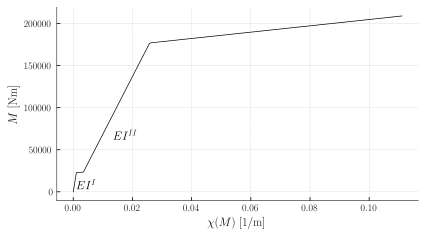

In [74]:
#| label: fig-mchi_diagramm
#| fig-cap: Momenten-Krümmungsdiagramm händisch ermittelt, definiert im positiven Bereich
M_R_num = np.float64(eq_M_R_num.rhs.evalf(4) /unit.m/unit.N)

chi_M_lambda = sp.lambdify((M, EI_I, EI_II, EI_III, M_r, M_y, M_R), eq_chi_M.rhs)

M_array = np.linspace(0,M_R_num * 2, 500)
chi_M_array = chi_M_lambda(M_array, *M_chi_params)

plt.plot(chi_M_array, M_array, color='black')

# Anmerkungen hinzufügen


plt.annotate('$EI^I$', xy=(0.0009, 15000), xytext=(0, -10), textcoords='offset pixels')
plt.annotate("$EI^{II}$", xy=(0.01, 50000), xytext=(10, 10), textcoords='offset pixels')

plt.xlabel(f'${sp.latex(chi_M)}$ [1/m]')
plt.ylabel(f'${sp.latex(M)}$ [Nm]')
plt.show()


##### Zustandslinien der Biegemomente

Da die Beziehung zwischen Biegemoment und Krümmung bestimmt ist, kann ein Krümmungsverlauf über die Stabachse ermittelt werden. Dieser ist abhängig von der Funktion der Biegemomente zur Stabachse. Die Zustandslinie der Biegemomente wird anhand des statischen Systems in @fig-system_2_lager. 



##### Zustandslinien der Krümmung

Die Funktion der Biegemomente $M(x)$ als Eingabe in die Funktion der Krümmung $\chi(M)$ resultiert zu folgender Zustandslinie der Krümmung.


In [78]:
chi_M_versuch_2 = chi_M_lambda(-M_x_array, *M_chi_params)


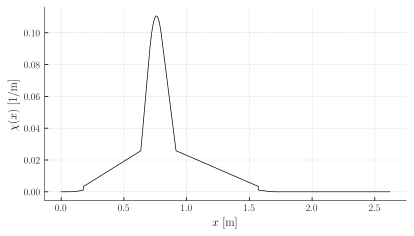

In [79]:
#| label: fig-chi_x_diagramm
#| fig-cap: Krümmungsverlauf für die Laststufe LS14 entlang der Stabachse

plt.plot(x_array, chi_M_versuch_2, color='black')

plt.xlabel(f'${sp.latex(x)}$ [m]')
plt.ylabel(f'$\chi(x)$ [1/m]')
plt.show()


#### Punktuelle Bestimmung der Deformation

Unter Anwendung der Arbeitsgleichung kann die Deformation nach @eq-arbeitsgleichung bestimmt werden.

$$
w = \int_0^l \bar{M}(x) \cdot \frac{M(x)}{EI} d_x
$${#eq-arbeitsgleichung}

Wobei $\frac{M(x)}{EI} = \chi(x)$ gilt.

Das heisst es gilt die Zustandslinien der Krümmung multipliziert mit der Zustandslinie der Biegemomente des virtuellen Kräftezustands über die Stablänge zu integrieren.

In [80]:
M_x_array_bar = M_x_lamb(1,x_array)

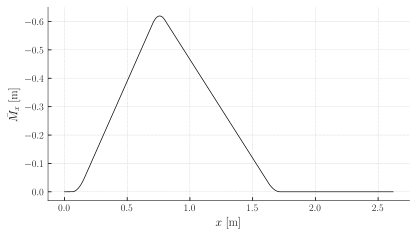

In [81]:
#| label: fig-m_y_diagramm_virtuell
#| fig-cap: Biegemomentenverlauf für den virtuellen Kräftezustand

plt.plot(x_array, M_x_array_bar, color='black')
plt.gca().invert_yaxis()

plt.xlabel(f'${sp.latex(x)}$ [m]')
plt.ylabel('$\\bar{M}_x$ [m]')
plt.show()

Unter Anwedung der @eq-arbeitsgleichung folgt die Deformation bei der Krafteinleitung $F_A$ zu:

In [82]:
eq_w_1_m_chi = unit.convert_to(sp.Eq(w_1, integrate.quad(lambda x: -M_x_lamb(1,x)*chi_M_lambda(-M_x_lamb(Laststufe,x), *M_chi_params), 0, 2.62)[0]*unit.m), unit.mm)

eq_w_1_m_chi.evalf(3)

C:\Users\Pascal Gitz\AppData\Local\Temp\ipykernel_33620\295205686.py:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  eq_w_1_m_chi = unit.convert_to(sp.Eq(w_1, integrate.quad(lambda x: -M_x_lamb(1,x)*chi_M_lambda(-M_x_lamb(Laststufe,x), *M_chi_params), 0, 2.62)[0]*unit.m), unit.mm)


w₁ = 18.2⋅millimeter

## Erweiterung Momenten-Krümmungsdiagramm

### Zugversteifung

Die bisherige Betrachtung beschränkt sich auf einen schlagartigen Wechsel von ungerissen zu vollständig gerissen. Dabei wird der Bereich zwischen den Rissen ebenfalls als gerissen angenommen. Mittels der Zugversteifung wird ein theoretischer Rissabstand ermittelt und zwischen den Rissen eine versteifte Wirkung zwischen Betonstahl und Beton angenommen (Verbundwirkung). Dies wird folgend auf das Versuchsbeispiel angewendet. Berücksichtigt wird dies via dem Ansatz von Marti.

Die Krümmungsdifferenez nach Marti beträgt:

In [83]:
eq_delta_chi_gamma = sp.Eq(delta_chi, sp.Mul(lamb / 2, f_ct * (1-rho_eff)/(rho_eff * E_s*(d-x_2)), evaluate=False))
eq_rho_eff = sp.Eq(rho_eff, (M_r*(d-x_2) * E_s / (f_ct * EI_II)+1-n)**-1)
eq_srm = sp.Eq(s_rm, lamb * diam_s*(1-rho_eff)/(4*rho_eff))

eq_sigma_sr0 = sp.Eq(sigma_sr0, F_z2 / A_s)
eq_w_r = sp.Eq(w_r, s_rm * (2*sigma_sr - lamb * sigma_sr0) / (2*E_s))
display(eq_delta_chi_gamma, eq_rho_eff, eq_srm,eq_sigma_sr0, eq_w_r)

                λ  f_ct⋅(1 - ρ_eff)
\Delta\chi(λ) = ─⋅─────────────────
                2 Eₛ⋅ρ_eff⋅(d - x₂)

                   1           
ρ_eff = ───────────────────────
                 Eₛ⋅Mᵣ⋅(d - x₂)
        -n + 1 + ──────────────
                 EI__{II}⋅f_ct 

      \oslashₛ⋅λ⋅(1 - ρ_eff)
sᵣₘ = ──────────────────────
             4⋅ρ_eff        

       F_z,2
σₛᵣ₀ = ─────
         Aₛ 

     sᵣₘ⋅(-λ⋅σₛᵣ₀ + 2⋅σₛᵣ)
wᵣ = ─────────────────────
              2⋅Eₛ        

In [84]:
eq_delta_chi_gamma_num = unit.convert_to(eq_subs(eq_delta_chi_gamma, eq_rho_eff, eq_M_r_num, eq_EI_II_num, eq_n_num, eq_x_2_num, eq_d_num).subs(params), unit.m)
eq_rho_eff_num = eq_subs(eq_rho_eff, eq_M_r_num, eq_EI_II_num, eq_n_num, eq_d_num, eq_x_2_num).subs(params)
display(eq_delta_chi_gamma_num.evalf(3), eq_rho_eff_num.evalf(3))

                0.00115⋅λ
\Delta\chi(λ) = ─────────
                  meter  

ρ_eff = 0.0757

In [85]:
eq_srm_num = eq_subs(eq_srm, eq_rho_eff_num).subs(params)

eq_srm_num.evalf(3)

sᵣₘ = 36.6⋅λ⋅millimeter

In [86]:
eq_chi_M_zugversteifung = sp.Eq(chi_M, sp.Piecewise((0,M<=0),(M/ (EI_I), (M > 0) & (M < eq_M_r.lhs)), (M/(EI_II)-eq_delta_chi_gamma_num.rhs.evalf(3)*unit.m, (M > eq_M_r.lhs) & (M < M_y)), (chi_M_linear.rhs , (M > M_y) & (M < M_R))))

display(eq_chi_M_zugversteifung)

       ⎧                        0                                for M ≤ 0    
       ⎪                                                                      
       ⎪                        M                                             
       ⎪                      ─────                             for M < Mᵣ    
       ⎪                      EI__I                                           
       ⎪                                                                      
       ⎪                              M                                       
χ(M) = ⎨              -0.00115⋅λ + ────────                for M > Mᵣ ∧ M < M_
       ⎪                           EI__{II}                                   
       ⎪                                                                      
       ⎪  ⎛    M_y         M_R   ⎞   M_R⋅M_y     M_R⋅M_y                      
       ⎪M⋅⎜- ──────── + ─────────⎟   ──────── - ─────────                     
       ⎪  ⎝  EI__{II}   EI__{III}⎠   EI__{II}   EI__

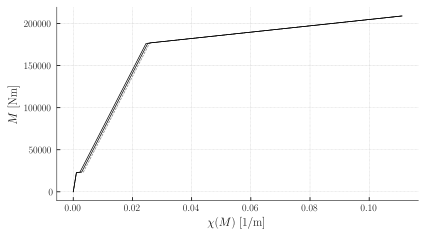

In [87]:
#| label: fig-mchi_diagramm
#| fig-cap: Momenten-Krümmungsdiagramm mit Zugversteifung ergänzt

eq_chi_M_zugversteifung_lambda = sp.lambdify((M,lamb, EI_I, EI_II, EI_III, M_r, M_y, M_R), eq_chi_M_zugversteifung.rhs)

chi_M_zugversteifung_array = eq_chi_M_zugversteifung_lambda(M_array,1, *M_chi_params)
chi_M_zugversteifung_array_05 = eq_chi_M_zugversteifung_lambda(M_array,0.5, *M_chi_params)

plt.plot(chi_M_array, M_array, color='gray', linestyle='dashed')
plt.plot(chi_M_zugversteifung_array, M_array, color='black')
plt.plot(chi_M_zugversteifung_array_05, M_array, color='black')


plt.xlabel(f'${sp.latex(chi_M)}$ [1/m]')
plt.ylabel(f'${sp.latex(M)}$ [Nm]')
plt.show()

In [88]:
chi_M_versuch_2_zugversteifung = eq_chi_M_zugversteifung_lambda(-M_x_array,1, *M_chi_params)


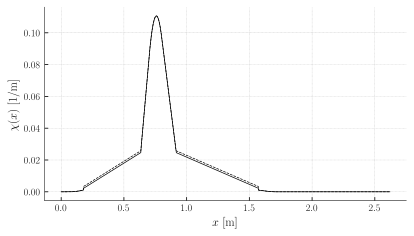

In [89]:
#| label: fig-chi_x_diagramm
#| fig-cap: Krümmungsverlauf für die Laststufe mit Zugversteifung
plt.plot(x_array, chi_M_versuch_2, color='black', linestyle='dashed')
plt.plot(x_array, chi_M_versuch_2_zugversteifung, color='black')

plt.xlabel(f'${sp.latex(x)}$ [m]')
plt.ylabel(f'$\chi(x)$ [1/m]')
plt.show()


In [90]:
eq_w_1_m_chi_zugversteifung = unit.convert_to(sp.Eq(w_1, integrate.quad(lambda x: -M_x_lamb(1,x)*eq_chi_M_zugversteifung_lambda(-M_x_lamb(Laststufe,x),1, *M_chi_params), 0, 2.62)[0]*unit.m), unit.mm)

eq_w_1_m_chi_zugversteifung.evalf(3)

C:\Users\Pascal Gitz\AppData\Local\Temp\ipykernel_33620\2311358037.py:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  eq_w_1_m_chi_zugversteifung = unit.convert_to(sp.Eq(w_1, integrate.quad(lambda x: -M_x_lamb(1,x)*eq_chi_M_zugversteifung_lambda(-M_x_lamb(Laststufe,x),1, *M_chi_params), 0, 2.62)[0]*unit.m), unit.mm)


w₁ = 17.8⋅millimeter